In [1]:
import sys
sys.path.append('./scripts/')
from robot import *
from scipy.stats import multivariate_normal ###多変量ガウス分布のモジュール###
from matplotlib.patches import Ellipse ###楕円の読み込み###

In [2]:
def sigma_ellipse(p, cov, n):  ###共分散行列p,cov,nを設定
    eig_vals, eig_vec = np.linalg.eig(cov)    ###行列covの固有値eig_vals,固有ベクトルeig_vecを導出 
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180 ###固有ベクトルeig_vecの角度angを導出
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5) 
    ###中心座標p,幅n*√(eig_vals[0]),高さn*√(eig_vals[1]),回転角度angの楕円の設定
    ###(((ここに楕円の説明)))

In [3]:
class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) ###多次元正規分布の乱数の設定###
        self.motion_noise_stds = motion_noise_stds ###ノイズの設定###
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  ###観測値のフィルタリング
        for d in observation:
            z = d[0] ###前期の観測値の設定###
            obs_id = d[1] ###今期の観測値の設定###
            
            ###離散化した出力行列Hの計算###
            mx, my = self.map.landmarks[obs_id].pos ###今期の観測値の座標設定###
            mux, muy, mut = self.belief.mean ###観測値の正規分布の設定###
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q) ###二つの観測値の距離の計算###
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]]) ###離散化した出力行列の計算###
            
            ###共分散行列Qの計算###
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos) ###出力行列と推定値の積の計算###
            distance_dev = self.distance_dev_rate*hmu[0]
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2])) ###共分散行列の計算###
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T))) ###カルマンゲインの計算###
            
            ###更新###
            self.belief.mean += K.dot(z - hmu) ###推定値meanの更新###
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov) ###誤差共分散covの更新###
            
    def motion_update(self, nu, omega, time): 
        if abs(nu) < 1e-10 and abs(omega) < 1e-10: ###速度や角速度が極端に小さい場合に処理を回避する###
            return

        v = self.motion_noise_stds ###ノイズの共分散行列の設定###
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time]) ###共分散行列Mtのガウス分布の計算###
        
        t = self.belief.mean[2] ###推定値の設定###
        A = time * np.array([[math.cos(t), 0.0], [math.sin(t), 0.0], [0.0, 1.0]]) ###ずれに比例して姿勢を決定する行列の計算###
        
        F = np.diag([1.0, 1.0, 1.0]) ###ヤコビ行列の計算###
        if abs(omega) < 10e-5: ###omega = 0のとき###
            F[0, 2] = - nu * time * math.sin(t) ###Fの3行1列の計算###
            F[1, 2] = nu * time * math.cos(t) ###Fの3行2列の計算###
        else: ###omega != 0のとき###
            F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t)) ###Fの3行1列の計算###
            F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t)) ###Fの3行2列の計算###
            
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T) ###共分散行列の更新###
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean) ###推定値の更新### 
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 10)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): 
    ###__init__をMclAgentからコピーして引数の整理###
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        ###"nn":1[m]あたりに生じる直進方向の分散
        ###"no":1[rad]あたりに生じる直進方向の分散
        ###"on":1[m]あたりに生じる回転方向の分散
        ###"oo":1[rad]あたりに生じる回転方向の分散
        super().__init__(nu, omega)
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds) 
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    ###selfの最終更新###
    def decision(self, observation=None):  ###kfagent2
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.kf.observation_update(observation)   #追加
        return self.nu, self.omega
    
    ###selfの描画###
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


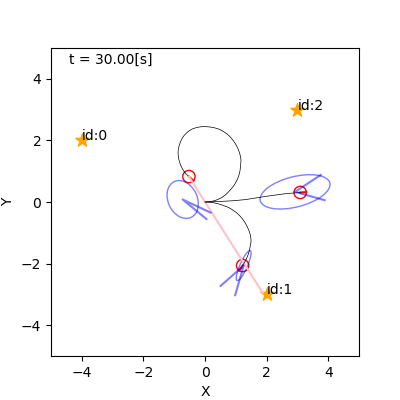

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき